# Showcase pre-emphasis and other added filters

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/audio_clean_v2/el_trim

/content/gdrive/MyDrive/audio_clean_v2/el_trim


In [ ]:
import librosa
audio, fs = librosa.load("meE00VS42Qw__U__S123---1849.480-1863.110.wav", sr=None)

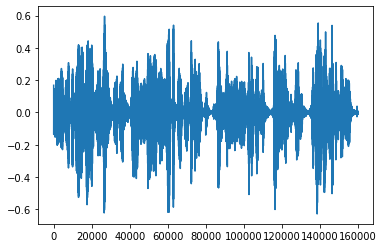

In [ ]:
import matplotlib.pyplot as plt

plt.plot(audio)

In [ ]:
from IPython.display import Audio, display

display(Audio(audio, rate=fs))

In [ ]:
import numpy as np
pre_emphasis = 0.97
emphasized_signal = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

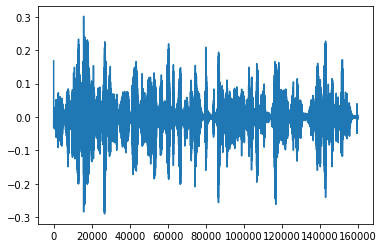

In [ ]:
plt.plot(emphasized_signal)

In [ ]:
display(Audio(emphasized_signal, rate=fs))

In [ ]:
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)
    return filter_banks

In [ ]:
fb = generate_fb_and_mfcc(audio, fs)

(998, 40)

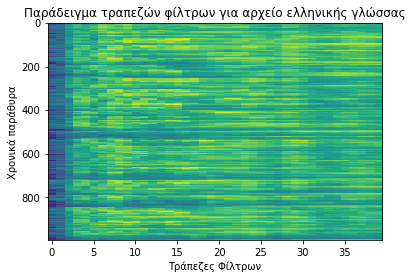

In [ ]:
plt.imshow(fb,interpolation='nearest', aspect='auto')
plt.xlabel("Τράπεζες Φίλτρων")
plt.ylabel("Χρονικά παράθυρα")
plt.title("Παράδειγμα τραπεζών φίλτρων για αρχείο ελληνικής γλώσσας")
fb.shape

In [ ]:
!pip install audiomentations

In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

def augment_input(audio_path,  num_samples, return_fb=True):

    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2, p=0.7),
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        Shift(min_fraction=0.5, max_fraction=0.5, p=0.5, fade = True),
    ])

    audio, fs = librosa.load(audio_path, sr=None)
    audios_out = num_samples*[None]

    for i in range(num_samples):
        audios_out[i] = augment(samples=audio, sample_rate=fs)

    if not return_fb:
        return audios_out

    if return_fb:
        fb_out = num_samples*[None]
        for i in range(num_samples):
            fb_out[i] = generate_fb_and_mfcc(audios_out[i], fs)
        return np.dstack(fb_out)


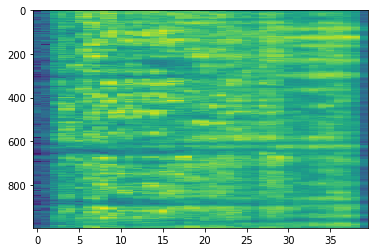

In [ ]:
fb_augmented = augment_input("meE00VS42Qw__U__S123---1849.480-1863.110.wav", num_samples=10, return_fb=True)
plt.imshow(fb_augmented[:,:,1],interpolation='nearest', aspect='auto')

In [ ]:
audio_augmented = augment_input("meE00VS42Qw__U__S123---1849.480-1863.110.wav", num_samples=10, return_fb=False)
display(Audio(audio_augmented[1], rate=fs))